In [9]:
from rlboard import *
import numpy as np
import random
import matplotlib.pyplot as plt

# Define board and actions
width, height = 8, 8
m = Board(width, height)
m.randomize(seed=13)

actions = {"U": (0, -1), "D": (0, 1), "L": (-1, 0), "R": (1, 0)}
action_idx = {a: i for i, a in enumerate(actions)}

In [10]:
# Random policy
def random_policy(m):
    return random.choice(list(actions))

# Walk episode using policy
def walk(m, policy, start_position=None):
    n = 0
    if start_position:
        m.human = start_position
    else:
        m.random_start()

    while True:
        if m.at() == Board.Cell.apple:
            return n
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1

        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human, a)
            if m.is_valid(new_pos) and m.at(new_pos) != Board.Cell.water:
                m.move(a)
                break
        n += 1

In [11]:
# Evaluate policy
def print_statistics(policy):
    s, w, n = 0, 0, 0
    for _ in range(100):
        z = walk(m, policy)
        if z < 0:
            w += 1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n:.2f}, eaten by wolf: {w} times")

In [15]:
# Reward function
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m, pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x in [Board.Cell.water, Board.Cell.wolf]:
        return end_reward
    if x == Board.Cell.apple:
        return goal_reward
    return move_reward

In [17]:
# Q table and learning
Q = np.ones((width, height, len(actions)), dtype=float) * (1.0 / len(actions))
lpath = []

def probs(v, eps=1e-4):
    v = v - v.min() + eps
    return v / v.sum()

# Q-learning training loop
for epoch in range(5000):
    m.random_start()
    n = 0
    cum_reward = 0
    while True:
        x, y = m.human
        v = probs(Q[x, y])
        a = random.choices(list(actions), weights=v)[0]
        dpos = actions[a]
        m.move(dpos, check_correctness=False)
        r = reward(m)
        cum_reward += r

        if r == end_reward or cum_reward < -1000:
            lpath.append(n)
            break

        alpha = np.exp(-n / 1e5)
        gamma = 0.5
        ai = action_idx[a]
        x_new, y_new = x + dpos[0], y + dpos[1]

        if 0 <= x_new < width and 0 <= y_new < height:
            q_next = Q[x_new, y_new].max()
        else:
            q_next = 0

        Q[x, y, ai] = (1 - alpha) * Q[x, y, ai] + alpha * (r + gamma * q_next)
        n += 1

In [18]:
# Policies from Q
def qpolicy_strict(m):
    x, y = m.human
    v = probs(Q[x, y])
    a = list(actions)[np.argmax(v)]
    return a

def qpolicy(m):
    x, y = m.human
    v = probs(Q[x, y])
    a = random.choices(list(actions), weights=v)[0]
    return a

Random Policy Stats:
Average path length = 33.16, eaten by wolf: 13 times

Q-Learning Policy Stats:
Average path length = 6.69, eaten by wolf: 7 times


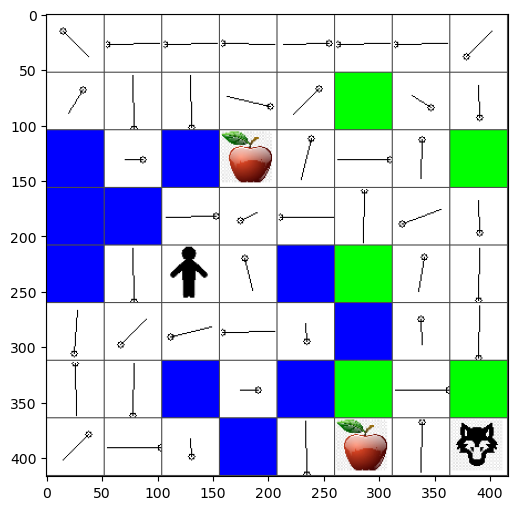

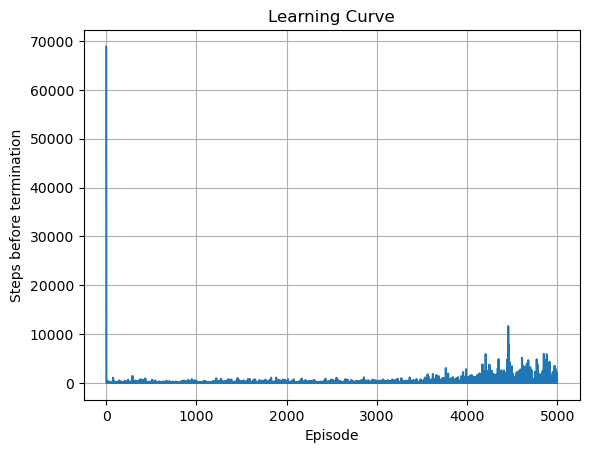

In [27]:
# Show final results
print("Random Policy Stats:")
print_statistics(random_policy)

print("\nQ-Learning Policy Stats:")
print_statistics(qpolicy)


# Plot board and learning curve
m.plot(Q)  # Visualize learned Q-values
plt.figure()
plt.plot(lpath)
plt.xlabel("Episode")
plt.ylabel("Steps before termination")
plt.title("Learning Curve")
plt.grid(True)
plt.show()